In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt
source_folder = "solo_classification_REMI_dataset"
destination_folder = "solo_classification_REMI_weights"

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [3]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

/home/cuakevinlex/miniconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [4]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[  4,   7,  55,  ...,  16,  40, 192],
        [  4,   7,  55,  ...,  27, 184,   1],
        [  4,   7,  55,  ...,  48,  90,   1],
        ...,
        [  4,  18,  26,  ...,   1,   1,   1],
        [  4,   7,  55,  ...,   1,   1,   1],
        [  4,  12,  17,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  4,   7,  35,  ...,   8,  40,  49],
        [  4,   7,  55,  ..., 129,   1,   1],
        [  4,   7,  55,  ..., 127,   1,   1],
        ...,
        [  4,   7,  55,  ...,   1,   1,   1],
        [  4,   7,  55,  ...,   1,   1,   1],
        [  4,   7,  55,  ...,   1,   1,   1]], device='cuda:0')
tensor([[ 4,  7, 55,  ..., 11, 59, 69],
        [ 4,  7, 35,  ..., 21, 65,  3],
        [ 4,  7, 55,  ..., 45, 54, 42],
        ...,
        [ 4,  7, 55,  ...,  1,  1,  1],
        [ 4,  7, 55,  ...,  1,  1,  1],
        [ 4,  7, 55,  ...,  1,  1,  1]], device='cuda:0')
tensor([[  4,   7,  55,  ...,  67,  28, 206],
        [  4,   7,  55,  ...,  32,  47, 179],
        [  4,   7,  35,

In [5]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
class LSTM(nn.Module):

    def __init__(self, dimension=64):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, notes, notes_len):
        notes_emb = self.embedding(notes)
        #print(notes_emb.size())
        packed_input = pack_padded_sequence(notes_emb, notes_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), notes_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        #print(out_reduced)
        notes_fea = self.drop(out_reduced)

        notes_fea = self.fc(notes_fea)
        notes_fea = torch.squeeze(notes_fea, 1)
        notes_out = torch.sigmoid(notes_fea)

        return notes_out

In [7]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [8]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long(), notes_len.long())

            loss = criterion(output, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = torch.round(output.detach().cpu())

            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long(), notes_len.long())
                        loss = criterion(output, labels.float())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=25)

Epoch [1/25], Step [16/825], Train Loss: 0.5797, Valid Loss: 0.9759
Model saved to ==> solo_classification_REMI_weights/model.pt
Model saved to ==> solo_classification_REMI_weights/metrics.pt
Epoch [1/25], Step [32/825], Train Loss: 0.9349, Valid Loss: 0.6893
Model saved to ==> solo_classification_REMI_weights/model.pt
Model saved to ==> solo_classification_REMI_weights/metrics.pt
Epoch Accuracy: 0.535171102661597
Epoch [2/25], Step [48/825], Train Loss: 0.7276, Valid Loss: 0.6873
Model saved to ==> solo_classification_REMI_weights/model.pt
Model saved to ==> solo_classification_REMI_weights/metrics.pt
Epoch [2/25], Step [64/825], Train Loss: 0.7060, Valid Loss: 0.6813
Model saved to ==> solo_classification_REMI_weights/model.pt
Model saved to ==> solo_classification_REMI_weights/metrics.pt
Epoch Accuracy: 0.4467680608365019
Epoch [3/25], Step [80/825], Train Loss: 0.6583, Valid Loss: 0.6760
Model saved to ==> solo_classification_REMI_weights/model.pt
Model saved to ==> solo_classifica

In [9]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classification_REMI_weights/metrics.pt


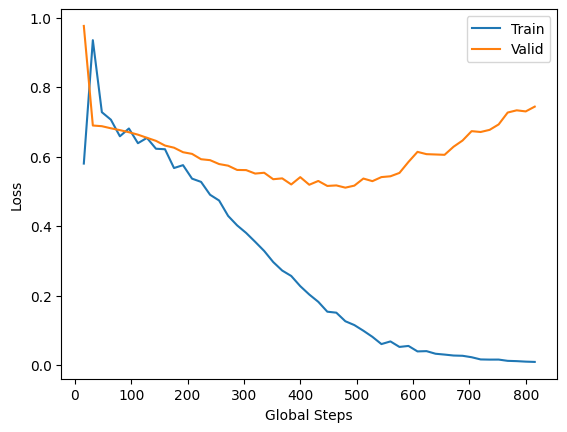

In [10]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [12]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long(), notes_len.long())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    ax.yaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== solo_classification_REMI_weights/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8020    0.7232    0.7606       112
           0     0.7480    0.8214    0.7830       112

    accuracy                         0.7723       224
   macro avg     0.7750    0.7723    0.7718       224
weighted avg     0.7750    0.7723    0.7718       224



In [13]:
from torchviz import make_dot
import hiddenlayer as hl

In [14]:
next(iter(test_iter)).notes

(tensor([[ 4,  7, 35,  ..., 17, 63,  5],
         [ 4, 19,  9,  ..., 14, 34,  3],
         [ 4,  7, 35,  ..., 36, 39,  1],
         ...,
         [ 4,  7, 35,  ...,  1,  1,  1],
         [ 4,  7, 35,  ...,  1,  1,  1],
         [ 4,  7, 55,  ...,  1,  1,  1]], device='cuda:0'),
 tensor([136, 136, 135, 133, 132, 129, 128, 128, 128, 128, 124, 124, 124, 124,
         124, 121, 121, 120, 120, 120, 120, 119, 118, 116, 116, 113, 112, 112,
         112, 112, 111, 110], device='cuda:0'))

In [15]:
def print_architecture(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    for (labels, (notes, notes_len)), _ in test_loader:           
        labels = labels.to(device)
        notes = notes.to(device)
        notes_len = notes_len.cpu()
        output = model(notes.long(), notes_len.long())
        
        
        transforms = [# hl.transforms.Prune('Constant'),
                      #hl.transforms.FoldDuplicates()
                     ] # Removes Constant nodes from graph.

        graph = hl.build_graph(model, (notes,notes_len), transforms=transforms)
        graph.theme = hl.graph.THEMES['blue'].copy()
        print(graph)
        graph.save('rnn_hiddenlayer', format='png')

        #output = (output > threshold).int()
        #y_pred.extend(output.tolist())
        #y_true.extend(labels.tolist())
        #print(dict(model.named_parameters()))
        #make_dot(output,params=dict(model.named_parameters())).render()
        break

    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
print_architecture(best_model, test_iter)

Model loaded from <== solo_classification_REMI_weights/model.pt


<ipython-input-6-304f365039f3>:24: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  out_forward = output[range(len(output)), notes_len - 1, :self.dimension]
/home/cuakevinlex/miniconda3/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:2095: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +
/home/cuakevinlex/miniconda3/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:2762: UserWarning: Exporting aten::index operator of advanced indexing in opset 9 is achieved by combination of mult

In [16]:
# print(best_model)